# Bayesian Blocks for Bump-Hunting 

The Bayesian Blocks (BB) binning algorithm (*link*) aims to choose optimal bin edges for a given histogram.  At it's heart, the algorithm chooses bin edges such that the content within the bin edges is consistent with a uniform distribution.  This binning method was initially developed for the astro community, in which signals appear as a uniform distribution on top of a noisy, constant background.  If the signal is statistically significant with respect to the background, then it should fall into its own bin in order to maximize the fitness metric, which is a function of the data and the binning.

When the nature of the signal and background change from the aforementioned distributions, one must be cautious when using the naive implementation of BB.  Typically when bump-hunting in particle physics, the signal appears as a Gaussian distribution, and the background is monotonically increasing or decreasing.  The naive BB algorithm may combine the increasing (decreasing) edge of the signal with the decreasing (increasing) edge of the background, and thus incorrectly identify the signal.

Instead, we will attempt to determine whether or not we should apply a finer binning to a signal region by examining the optimal binning for the background-only and signal-only cases.

First, let's running generate a background distribution, signal distribution, run some sanity checks, etc.  Then we extract both the background-only binning and the signal-only binning.  This example looks at simulation that mimics the Hgg analysis, where the background is a decaying gg spectrum from 100 GeV < Mgg < 180 GeV, and the signal is a Gaussian-like Higgs boson peak, initially at 125.5 GeV with a width of ~3 GeV.

In [109]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12,8)


loaded
Performing fit with initial parameters:
a1	= 0.000
a2	= 0.000
a3	= 0.000
Fit finished with status: 0
Calculating covariance of parameters...


RESULTS
-------
a1	= -0.957 +/- 0.016
a2	= 0.399 +/- 0.023
a3	= -0.126 +/- 0.024


CORRELATION MATRIX
------------------
[[ 1.    -0.455  0.133]
 [-0.455  1.    -0.448]
 [ 0.133 -0.448  1.   ]]


Performing fit with initial parameters:
mu	= 120.000
sigma	= 2.000
Fit finished with status: 0
Calculating covariance of parameters...


RESULTS
-------
mu	= 125.772 +/- 0.181
sigma	= 2.775 +/- 0.128


CORRELATION MATRIX
------------------
[[  1.000e+00  -2.531e-05]
 [ -2.531e-05   1.000e+00]]


Performing fit with initial parameters:
C	= 0.010
mu	= 125.000
sigma	= 2.000
a1	= 0.000
a2	= 0.000
a3	= 0.000
Fit finished with status: 0
Calculating covariance of parameters...


RESULTS
-------
C	= 0.038 +/- 0.010
mu	= 126.494 +/- 0.792
sigma	= 4.286 +/- 0.879
a1	= -0.957 +/- 0.016
a2	= 0.431 +/- 0.031
a3	= -0.165 +/- 0.035


CORRELATION MATRIX
--------

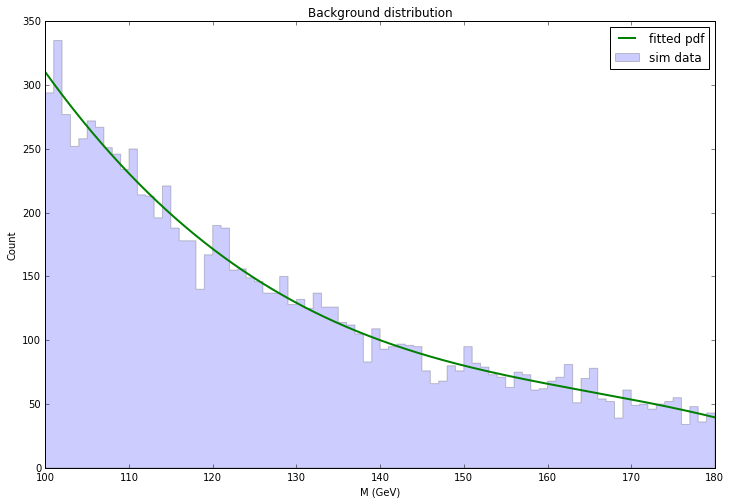

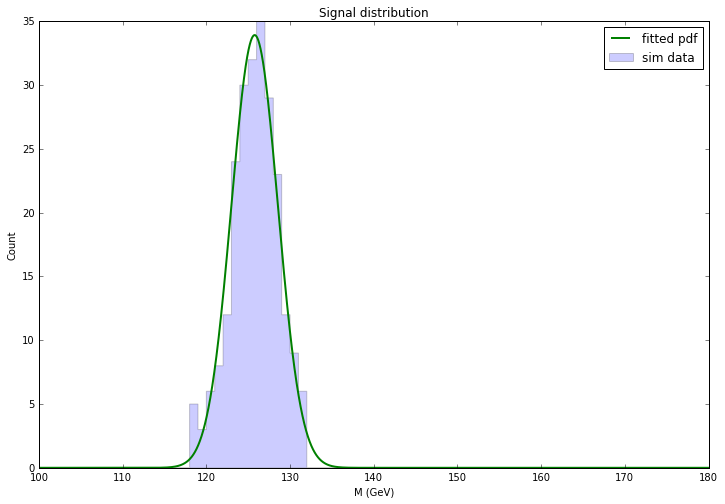

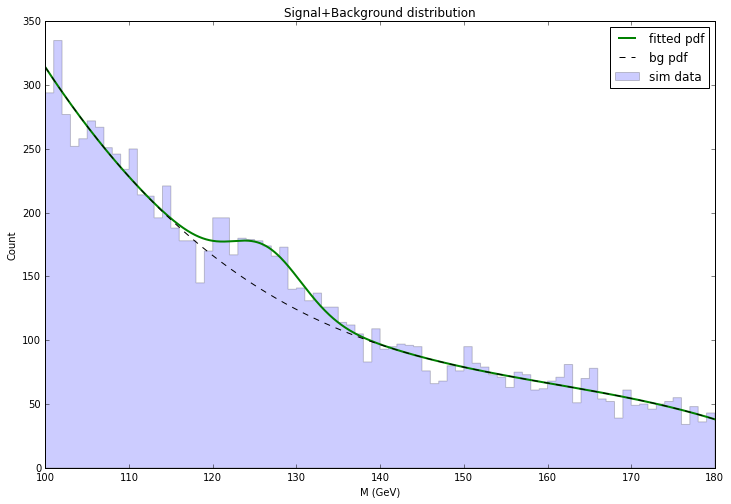

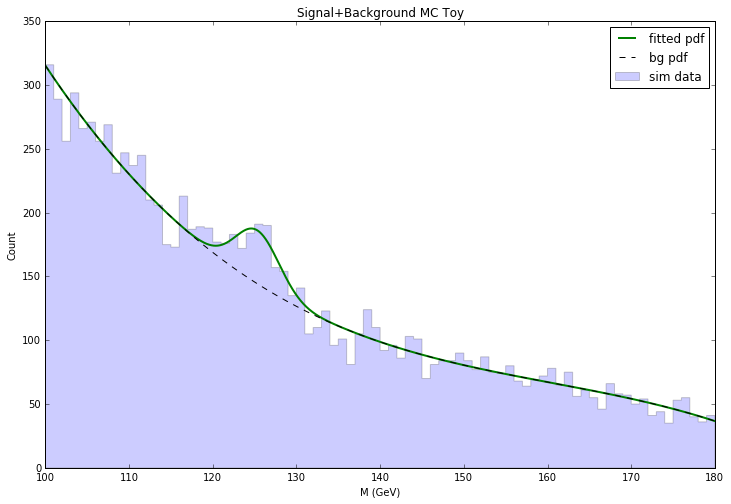

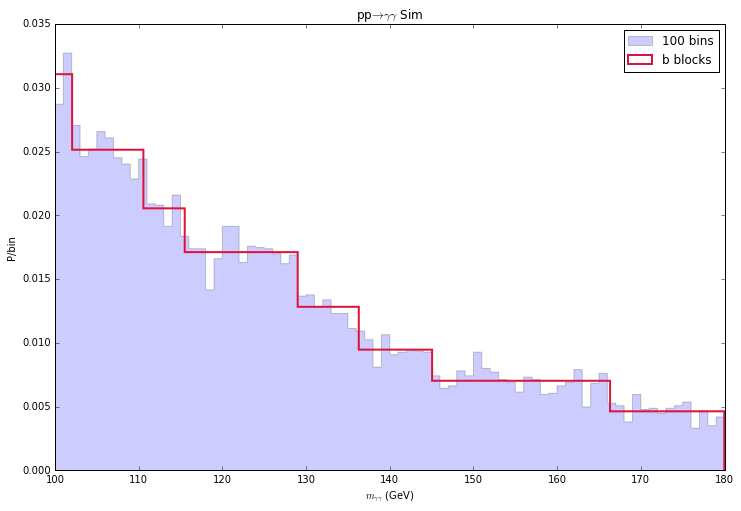

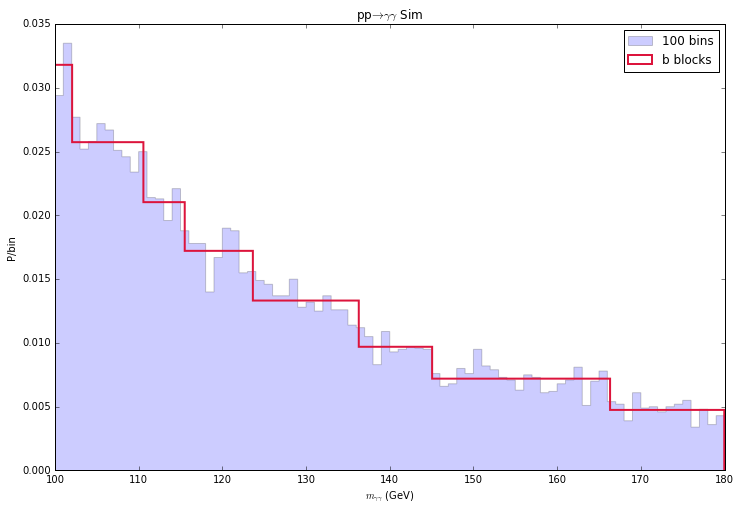

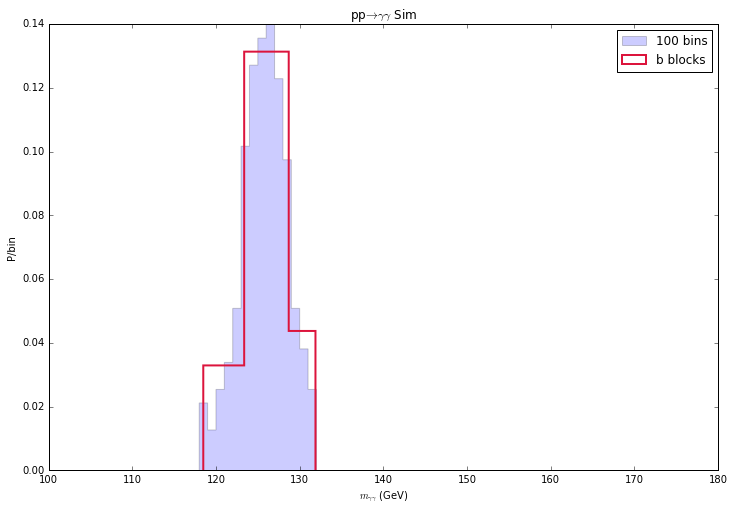

In [143]:
%run hgg_comp.py
plt.show()

We now have optimal BB binning for a background-only and a signal-only distribution.  Here are the bin edges:

In [111]:
be_bg

array([ 100.003,  102.052,  110.567,  115.506,  123.647,  136.3  ,
        145.063,  166.323,  179.965])

In [112]:
be_sig

array([ 118.483,  123.369,  128.692,  131.887])

In [113]:
print np.mean(be_sig)

125.607563045


Now let's make a hybrid binning based on the signal and the background:

In [114]:
be_hybrid = np.concatenate([be_bg[be_bg<be_sig[0]], be_sig, be_bg[be_bg>be_sig[-1]]])

In [115]:
be_hybrid

array([ 100.003,  102.052,  110.567,  115.506,  118.483,  123.369,
        128.692,  131.887,  136.3  ,  145.063,  166.323,  179.965])

We've replaced the bin edges for the background-only distribution with the edges for the signal-only distribution.  Let's see how that compares with the bg-only binning.

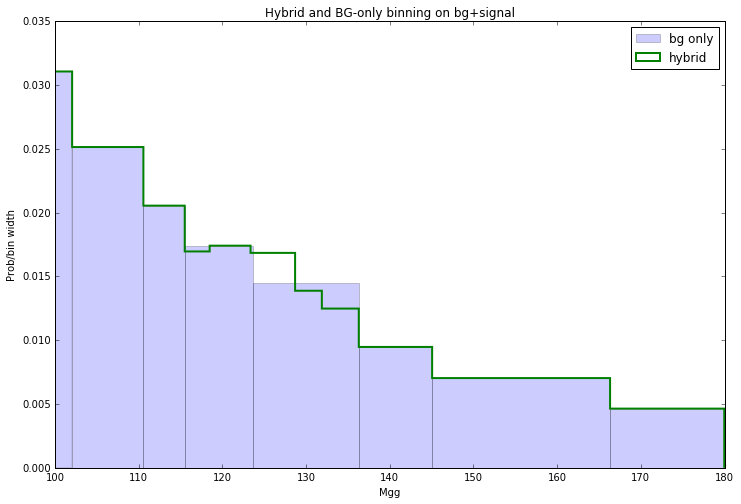

In [116]:
plt.hist(data_bg_sig,be_bg,alpha=0.2,normed=True, label='bg only')
plt.hist(data_bg_sig,be_hybrid,normed=True, histtype='step', linewidth = 2, label='hybrid')
plt.title('Hybrid and BG-only binning on bg+signal')
plt.xlabel('Mgg')
plt.ylabel('Prob/bin width')
plt.legend()
plt.show()

So we have a bin with obvious excess w.r.t the bg-only binning, and one with a fairly sizable deficit.  What would happen if we took the same relative signal bins, but placed them somewhere else (where there was no injected signal)?

In [136]:
print np.mean(be_sig)

125.607563045


In [117]:
bw_sig = be_sig[1:] - be_sig[:-1]

In [118]:
bw_sig

array([ 4.886,  5.322,  3.195])

In [119]:
be_sig_shift_high = np.cumsum(np.insert(bw_sig,0,140))

In [120]:
be_sig_shift_high

array([ 140.   ,  144.886,  150.208,  153.403])

In [121]:
be_sig_shift_low = np.cumsum(np.insert(bw_sig,0,105))

In [122]:
be_sig_shift_low

array([ 105.   ,  109.886,  115.208,  118.403])

In [123]:
be_hybrid_shift_high = np.concatenate([be_bg[be_bg<be_sig_shift_high[0]], be_sig_shift_high, be_bg[be_bg>be_sig_shift_high[-1]]])

In [124]:
be_hybrid_shift_low = np.concatenate([be_bg[be_bg<be_sig_shift_low[0]], be_sig_shift_low, be_bg[be_bg>be_sig_shift_low[-1]]])

In [125]:
be_hybrid_shift_high, be_hybrid_shift_low

(array([ 100.003,  102.052,  110.567,  115.506,  123.647,  136.3  ,
         140.   ,  144.886,  150.208,  153.403,  166.323,  179.965]),
 array([ 100.003,  102.052,  105.   ,  109.886,  115.208,  118.403,
         123.647,  136.3  ,  145.063,  166.323,  179.965]))

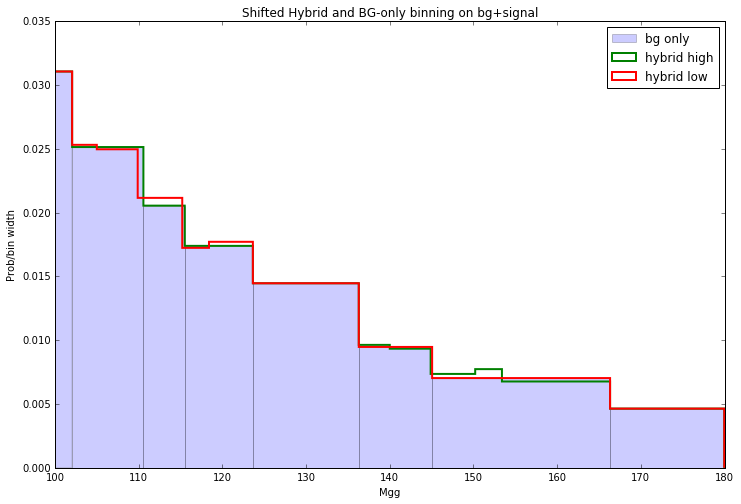

In [126]:
plt.hist(data_bg_sig,be_bg,alpha=0.2,normed=True, label='bg only')
plt.hist(data_bg_sig,be_hybrid_shift_high, normed=True, histtype='step', linewidth = 2, label='hybrid high')
plt.hist(data_bg_sig,be_hybrid_shift_low, normed=True, histtype='step', linewidth = 2, label='hybrid low')
plt.title('Shifted Hybrid and BG-only binning on bg+signal')
plt.xlabel('Mgg')
plt.ylabel('Prob/bin width')
plt.legend()

Qualitatively, the excesses and deficits are much smaller than those where a signal occurs, as expected. If we want to take a generic signal model and scan it across this distribution in order to find the optimal placement, we can attempt to maximize excesses and depletions.  First we need a way to quantify the total excess/depletion.

In [127]:
be_hybrid_shift_high

array([ 100.003,  102.052,  110.567,  115.506,  123.647,  136.3  ,
        140.   ,  144.886,  150.208,  153.403,  166.323,  179.965])

In [128]:
bc_bg, be_bg = np.histogram(data_bg_sig,be_bg,density=True)
bc_hybrid, be_hybrid = np.histogram(data_bg_sig,be_hybrid,density=True)
bc_hybrid_low, be_hybrid_low = np.histogram(data_bg_sig,be_hybrid_shift_low,density=True)
bc_hybrid_high, be_hybrid_high = np.histogram(data_bg_sig,be_hybrid_shift_high,density=True)

In [129]:
print get_mismatch_metric(bc_bg, be_bg, bc_hybrid, be_hybrid)
print get_mismatch_metric(bc_bg, be_bg, bc_hybrid_low, be_hybrid_low)
print get_mismatch_metric(bc_bg, be_bg, bc_hybrid_high, be_hybrid_high)

0.00530955919379
0.00215728304068
0.00165327687312


This mismatch metric is the sum of the absolute difference of the bin contents for the signal bins vs the bg bins.  Care has been taken to properly proportion bin content differences when a signal bin overlaps a bg bin.

$$\textrm{mismatch metric} = \sum_{n=0}^{\textrm{max signal bins}}\left|\textrm{signal bin value}_n - \textrm{bg bin value}(n)\right|$$



In [130]:
max_metric = 0
signal_loc = -1
be_hybrid_best = None
for mass in range(101,165):
    be_sig_shift_tmp = np.cumsum(np.insert(bw_sig,0,mass))
    be_hybrid_tmp = np.concatenate([be_bg[be_bg<be_sig_shift_tmp[0]], be_sig_shift_tmp, be_bg[be_bg>be_sig_shift_tmp[-1]]])
    bc_hybrid_tmp, be_hybrid_tmp = np.histogram(data_bg_sig,be_hybrid_tmp,density=True)
    tmp_metric = get_mismatch_metric(bc_bg, be_bg, bc_hybrid_tmp, be_hybrid_tmp)
    if tmp_metric > max_metric:
        max_metric = tmp_metric
        signal_loc = np.mean(be_sig_shift_tmp)
        be_hybrid_best = be_hybrid_tmp
print signal_loc, max_metric
    

131.124457566 0.00851357565961


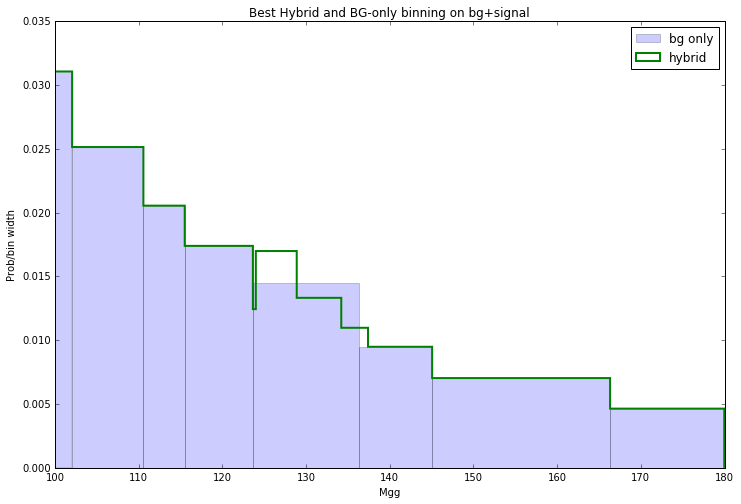

In [131]:
plt.hist(data_bg_sig,be_bg,alpha=0.2,normed=True, label='bg only')
plt.hist(data_bg_sig,be_hybrid_best,normed=True, histtype='step', linewidth = 2, label='hybrid')
plt.title('Best Hybrid and BG-only binning on bg+signal')
plt.xlabel('Mgg')
plt.ylabel('Prob/bin width')
plt.legend()
plt.show()

Looks like there are some issues with this method.  There needs to be more care in calculating the metric; there is no requirement that the middle signal bin be maximized, so it looks like the leftmost bin is picking up the signal content.  There should be extra care to make sure that the hybrid binning doesn't create extremely narrow bins, so a minimum bin width should be enforced, and small bins should be removed.

Here's a new algo that places extra weight on the middle single bin:

In [161]:
max_metric = 0
signal_loc = -1
be_hybrid_best = None
for mass in np.linspace(110,165,500):
    be_sig_shift_tmp = np.cumsum(np.insert(bw_sig,0,mass))
    be_hybrid_tmp = np.concatenate([be_bg[be_bg<be_sig_shift_tmp[0]], be_sig_shift_tmp, be_bg[be_bg>be_sig_shift_tmp[-1]]])
    bc_hybrid_tmp, be_hybrid_tmp = np.histogram(data_bg_sig,be_hybrid_tmp,density=True)
    tmp_metric = get_mismatch_metric_v2(bc_bg, be_bg, bc_hybrid_tmp, be_hybrid_tmp, be_sig_shift_tmp[1])
    if tmp_metric > max_metric:
        max_metric = tmp_metric
        signal_loc = np.mean(be_sig_shift_tmp)
        be_hybrid_best = be_hybrid_tmp
print signal_loc, max_metric, be_hybrid_best

130.020249149 0.0192100312114 [ 100.003  102.052  110.567  115.506  122.896  127.782  133.104  136.299
  136.3    145.063  166.323  179.965]


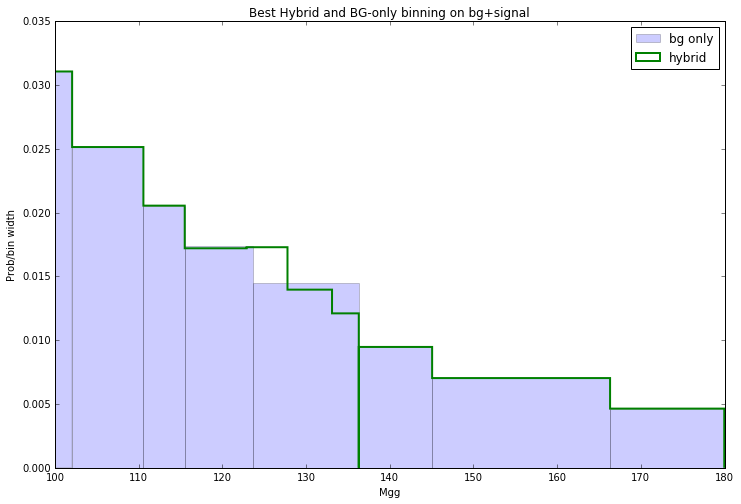

In [162]:
plt.hist(data_bg_sig,be_bg,alpha=0.2,normed=True, label='bg only')
plt.hist(data_bg_sig,be_hybrid_best,normed=True, histtype='step', linewidth = 2, label='hybrid')
plt.title('Best Hybrid and BG-only binning on bg+signal')
plt.xlabel('Mgg')
plt.ylabel('Prob/bin width')
plt.legend()
plt.show()

These results are much better, however the signal peak is shifted ~1.0 GeV from the injection point.  I think the background shape is still biasing the result somewhat, as the falling spectrum gives extra weight to the higher-mass signal events and lower weight to the low mass points.  This next iteration only considers the excess in the central signal bin, and ignores all other bins.

In [159]:
max_metric = 0
signal_loc = -1
be_hybrid_best = None
for mass in np.linspace(110,165,500):
    be_sig_shift_tmp = np.cumsum(np.insert(bw_sig,0,mass))
    be_hybrid_tmp = np.concatenate([be_bg[be_bg<be_sig_shift_tmp[0]], be_sig_shift_tmp, be_bg[be_bg>be_sig_shift_tmp[-1]]])
    bc_hybrid_tmp, be_hybrid_tmp = np.histogram(data_bg_sig,be_hybrid_tmp,density=True)
    tmp_metric = get_mismatch_metric_v3(bc_bg, be_bg, bc_hybrid_tmp, be_hybrid_tmp, be_sig_shift_tmp[1])
    if tmp_metric > max_metric:
        max_metric = tmp_metric
        signal_loc = np.mean(be_sig_shift_tmp)
        be_hybrid_best = be_hybrid_tmp
print signal_loc, max_metric, be_hybrid_best

125.831872396 0.00682672593593 [ 100.003  102.052  110.567  115.506  118.707  123.593  128.916  132.111
  136.3    145.063  166.323  179.965]


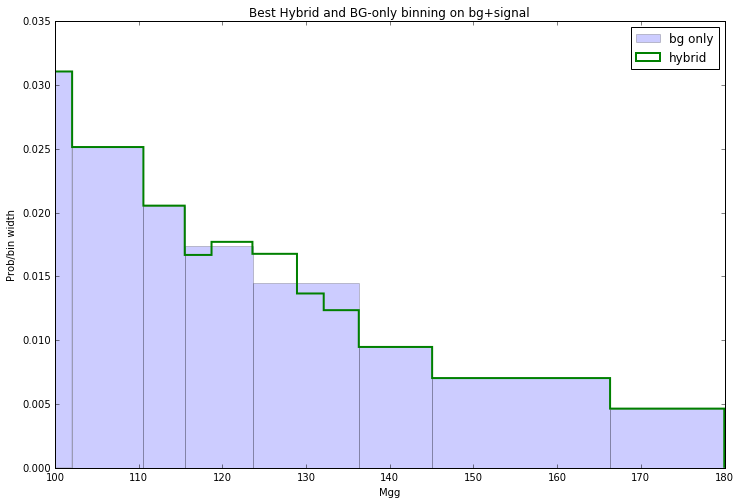

In [160]:
plt.hist(data_bg_sig,be_bg,alpha=0.2,normed=True, label='bg only')
plt.hist(data_bg_sig,be_hybrid_best,normed=True, histtype='step', linewidth = 2, label='hybrid')
plt.title('Best Hybrid and BG-only binning on bg+signal')
plt.xlabel('Mgg')
plt.ylabel('Prob/bin width')
plt.legend()
plt.show()

This result is extremely good.  I will have to check whether or not it is robust to many bg and signal toys of varying strength, but currently this is very close to the reco mass of 125.9.